# Forward simulation in Stan

Try to simulate the model directly from Stan code. To get this working will likely need to write up the vMF sample in Stan as an RNG.

In [15]:
%matplotlib inline
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import numpy as np
import pystan
from fancy import *

In [16]:
# read in relevant data
source_file = 'data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

## Set up the parameters

In [17]:
# set source parameters
F_T = 200 # total flux
f = 0.7 # associated fraction
F_A = f * F_T # source flux

# set the propagation parameter
kappa = 100

## Calculate the weights

In [18]:
# distances to AGN
D = data.source['AGN'].distance

# number of AGN
N_A = len(D) 

# function to calculate the weights
def get_weights(D, f):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    # scale to f
    w = w * f
    return w

# how many events to simulate for each source?
w = get_weights(D, f)
F = []
for w_k in w:
    F.append(int(round(w_k * F_T)))
print ('Total source flux:', sum(F))
print ('f * F_T:', f * F_T)

Total source flux: 139
f * F_T: 140.0


## Get the AGN positions as unit vectors

In [19]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Make a wapper class to store output
class Direction():
    """
    Input the unit vector vMF samples and 
    store x, y, and z and galactic coordinates 
    of direction in Mpc.
    
    :param omega_k: unit vector
    :param norm: unit vector = vector / norm
    """
    
    def __init__(self, omega_k, norm):
        self.unit_vector = omega_k 
        self.norm = norm
        self.x = np.transpose(omega_k)[0] * self.norm
        self.y = np.transpose(omega_k)[1] * self.norm
        self.z = np.transpose(omega_k)[2] * self.norm
        self.d = SkyCoord(self.x, self.y, self.z, 
                          unit = 'mpc', 
                          representation_type = 'cartesian', 
                          frame = 'galactic')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [20]:
# get the AGN positions as unit vectors
# get the positions of the sources
skycoords = data.source['AGN'].coord

# convert to cartesian coordinates
varpi = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 
varpi = np.transpose(varpi)
N_A = len(varpi)

# convert to unit vectors and store as Direction objects
mus = []
for i in range(N_A):
    norm = np.linalg.norm(varpi[i])
    mu = varpi[i] / norm
    mus.append(Direction(mu, norm))

## Simulating the data in Stan

Try to simulate data from the Stan model and compare with the python results. The generative stan model is stored in `gen_simplified_model.stan`. 

In [21]:
# define the "data" (really parameters for the simulation)



varpi_flat = []
for mu in mus:
    varpi_flat.append(mu.unit_vector)
weights = [1-f] + list(w)

sim_input = {'N_A' : 17,
             'varpi' : varpi_flat,
             'F_T' : F_T,
             'f' : f,
             'w' : weights,
             'kappa' : 1000}

In [22]:
# compile and "fit" the model
sm = pystan.StanModel(file = 'gen_simplified_model.stan')
fit = sm.sampling(data = sim_input, iter = 1, chains = 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54842c543ec465f2b197251aac956262 NOW.
/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Plot the results

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


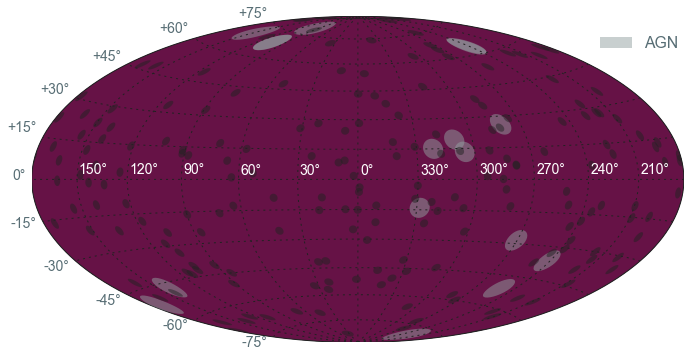

In [23]:
omega_sim = fit.extract(['omega'])['omega'].reshape([F_T, 3])
omega_sim = Direction(omega_sim, 10)

# plot the results on a skymap
# sources
fig, skymap = data.show()
# simulated data
label = True
for lon, lat in np.nditer([omega_sim.lons, omega_sim.lats]):
    if label:
        skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                      label = 'simulated data')
        label = False
    else:
        skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)